In [1]:
# Uncomment to upgrade packages
#!pip3 install pandas --upgrade --quiet
#!pip3 install numpy  --upgrade --quiet
#!pip3 install scipy --upgrade --quiet
#!pip3 install statsmodels  --upgrade --quiet
#!pip3 install seaborn  --upgrade --quiet
#!pip3 install matplotlib  --upgrade --quiet
#!pip3 install scikit-learn  --upgrade  --quiet
#!pip install scikit-optimize  --quiet
#!pip install -U --quiet yellowbrick

In [2]:
# Imports de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns      
import missingno as msno
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from scipy import stats
from matplotlib.lines import Line2D

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Definiciones
RND = 16 

sns.set(style="whitegrid", font_scale=1.05)

    # Definiciones de paletas
tennis_palette = ['#FF6B6B', '#4ECDC4']

# Funciones auxiliares
def format_pval(p):
    """Formatea p-value: decimal si p >= 1e-3, si no en notación mantisa*10^{exp} (LaTeX)."""
    if p == 0:
        return r"$0$"
    exp = int(np.floor(np.log10(p)))
    if exp >= -3:
        return f"{p:.4f}"                # p mostrado como decimal (4 decimales)
    else:
        mant = p / (10.0**exp)
        # devolver string LaTeX, por ejemplo: $1.94\times10^{-19}$
        return rf"${mant:.2f}\times10^{{{exp}}}$"


# quitar warnings:
import warnings
warnings.filterwarnings("ignore", message="findfont:.*") 

from time import time
from datetime import timedelta
init_time = time()

# Práctica de APA

Autores: Oriol Farrés y Marc Gil

Nosotros haremos un modelo de ML para predecir el ganador de partidos de tenis. Utilizaremos el repo de Jeff Sackman entre 2011 y 2024 como dataset (estamos hablando de más de 39k filas de datos). Es un problema de clasificación (binaria). Utilizaremos aprendizaje automático supervisado.

Como comentamos en clase, entregaremos solo un exploratorio mínimo (muy mínimo, sin entrear en hacer feature engineering) y una regresión logística para demsostrar que nuestro modelo obtiene mejores resultados que la aleatoriedad (50%).

## 1-Preparación de los datos

In [3]:
matches = pd.read_csv('./data/matches_post1.csv')
matches.head()
matches.shape

,tourney_name,surface,draw_size,tourney_date,match_num,best_of,round,year,month,tourney_points,...,player2_winrate,player2_ytd_wins,player2_ytd_losses,player2_ytd_winrate,player1_last10_wins,player1_last10_losses,player1_last10_winrate,player2_last10_wins,player2_last10_losses,player2_last10_winrate
0,Brisbane,Hard,32,20110102,1,3,R32,2011,1,250,...,0.0,0,0,0.0,0,0,0.0,0,0,0.0
1,Brisbane,Hard,32,20110102,2,3,R32,2011,1,250,...,0.0,0,0,0.0,0,0,0.0,0,0,0.0
2,Brisbane,Hard,32,20110102,3,3,R32,2011,1,250,...,0.0,0,0,0.0,0,0,0.0,0,0,0.0
3,Brisbane,Hard,32,20110102,4,3,R32,2011,1,250,...,0.0,0,0,0.0,0,0,0.0,0,0,0.0
4,Brisbane,Hard,32,20110102,5,3,R32,2011,1,250,...,0.0,0,0,0.0,0,0,0.0,0,0,0.0


(39533, 47)

Vemos que tenemos 47 features (columnas) por cada fila de datos, que tenemos más de 39k partidos.

Obviamente nos reservamos el derecho para poder añadir features que puedan ser interesantes, para ver a qué nivel de precisión somos capaces de llegar: 70%? 80%?

Vamos a ver qué variables tratar, las distinguiremos por simplicidad para este exploratorio mínimo:

1. Categóricas: Aquellas con NaN en los campos `unique`, `top` y `freq`.
2. Numéricas: Las otras.

In [4]:
display(matches.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
tourney_name,39533,1078,Roland Garros,1778,NaN,NaN,NaN,NaN,NaN,NaN,NaN
surface,39481,4,Hard,23058,NaN,NaN,NaN,NaN,NaN,NaN,NaN
draw_size,39533.0,NaN,NaN,NaN,57.478309,42.141537,2.0,32.0,32.0,96.0,128.0
tourney_date,39533.0,NaN,NaN,NaN,20174403.606127,41142.947638,20110102.0,20140319.0,20170731.0,20210726.0,20241218.0
match_num,39533.0,NaN,NaN,NaN,167.273038,151.257867,1.0,21.0,190.0,283.0,1701.0
best_of,39533.0,NaN,NaN,NaN,3.433967,0.824393,3.0,3.0,3.0,3.0,5.0
round,39533,9,R32,12112,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,39533.0,NaN,NaN,NaN,2017.383452,4.113654,2011.0,2014.0,2017.0,2021.0,2024.0
month,39533.0,NaN,NaN,NaN,5.53105,3.007147,1.0,3.0,5.0,8.0,12.0
tourney_points,39533.0,NaN,NaN,NaN,735.278122,664.831526,0.0,250.0,500.0,1000.0,2000.0


Ahora vamos a definir variables que nos serán útiles para el exploratorio mínimo.

In [5]:
target = 'winner'
columns = matches.columns.tolist()
columns_no_target = [col for col in columns if col != target]

# numerical_columns y categorical_columns no incluyen la columna target

# Columnas numéricas: aquellas donde 'unique' NO es NaN en describe()
describe_all = matches.describe(include='all').T
numerical_columns = describe_all[describe_all['unique'].isna()].index.tolist()
# Tenemos modelado target como numérica, la quitamos
numerical_columns.remove(target)

# Columnas categóricas: todas las columnas excepto las numéricas
categorical_columns = [col for col in columns if col not in numerical_columns]
categorical_columns.remove(target)

print(f"Columnas numéricas ({len(numerical_columns)}): {numerical_columns}")
print(f"\nColumnas categóricas ({len(categorical_columns)}): {categorical_columns}")

Columnas numéricas (35): ['draw_size', 'tourney_date', 'match_num', 'best_of', 'year', 'month', 'tourney_points', 'player1_ht', 'player1_age', 'player1_rank', 'player1_rank_points', 'player2_ht', 'player2_age', 'player2_rank', 'player2_rank_points', 'player1_h2h_wins', 'player2_h2h_wins', 'player1_total_wins', 'player1_total_losses', 'player1_winrate', 'player1_ytd_wins', 'player1_ytd_losses', 'player1_ytd_winrate', 'player2_total_wins', 'player2_total_losses', 'player2_winrate', 'player2_ytd_wins', 'player2_ytd_losses', 'player2_ytd_winrate', 'player1_last10_wins', 'player1_last10_losses', 'player1_last10_winrate', 'player2_last10_wins', 'player2_last10_losses', 'player2_last10_winrate']

Columnas categóricas (11): ['tourney_name', 'surface', 'round', 'player1_entry', 'player1_name', 'player1_hand', 'player1_ioc', 'player2_entry', 'player2_name', 'player2_hand', 'player2_ioc']


Antes de hacer la división entre conjuntos de entrenamiento y validación, hay que tener en cuenta un factor muy importante:

No podemos dividir de forma random el dataset entre entrenamiento y validación, porqué tendríamos **data leakage**. Por ejemplo, el modelo sabría datos de un partido de 2022 de Carlos Alcaraz, donde ya es una estrella, para predecir un partido de 2019 de Carlos Alcaraz (sus inicios), dónde no lo conocía. Aún quitando los identificadores el modelo es capaz de aprender patrones y relacionar qué tienen modelos de juego similares (es el mismo jugador) y estaría haciendo trampa.

Por eso hemos decidido dividir en entrenamiento (partidos de 2011 a 2022) y validación (partidos de 2023 a 2024).

In [6]:
matches['tourney_date'] = matches['tourney_date'].astype(str)

# Extraer el año de la fecha (los primeros 4 caracteres, formato YYYYMMDD)
matches['year'] = matches['tourney_date'].str[:4].astype(int)

# División temporal: 2011-2022 para train, 2023-2024 para test
matches_train = matches[matches['year'] <= 2022].copy()
matches_test = matches[matches['year'] >= 2023].copy()

n_train = len(matches_train)
n_test = len(matches_test)
n_total = len(matches)
pct_train = (n_train / n_total) * 100
pct_test = (n_test / n_total) * 100

print(f"ESTADÍSTICAS DE LA DIVISIÓN:")
print(f"   Total de partidos:           {n_total:,}")
print(f"\n    TRAIN (2011-2022):")
print(f"      • Cantidad:               {n_train:,} partidos")
print(f"      • Porcentaje:             {pct_train:.2f}%")

print(f"\n     TEST (2023-2024):")
print(f"      • Cantidad:               {n_test:,} partidos")
print(f"      • Porcentaje:             {pct_test:.2f}%")

print(f"\n     PROPORCIÓN TRAIN/TEST:    {pct_train:.1f}% / {pct_test:.1f}%")

ESTADÍSTICAS DE LA DIVISIÓN:
   Total de partidos:           39,533

    TRAIN (2011-2022):
      • Cantidad:               33,473 partidos
      • Porcentaje:             84.67%

     TEST (2023-2024):
      • Cantidad:               6,060 partidos
      • Porcentaje:             15.33%

     PROPORCIÓN TRAIN/TEST:    84.7% / 15.3%


## 2-Visualización de los datos

### 2.1- Variable Objetivo: ``winner``

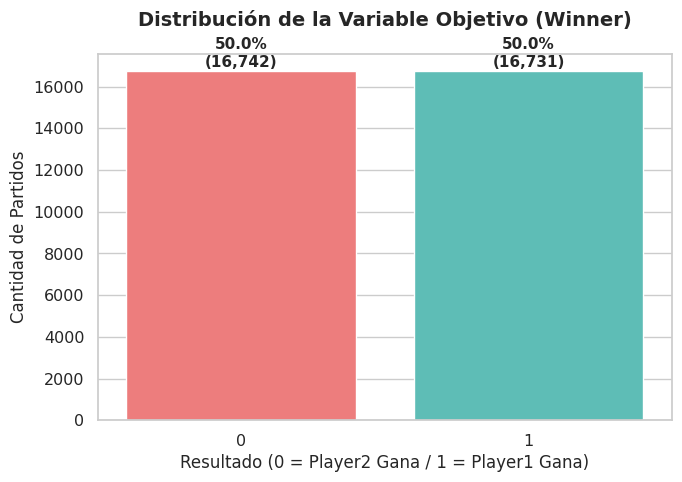

In [7]:
# Gráfico simple de la distribución de Winner
plt.figure(figsize=(7, 5))

# Crear el gráfico con el método correcto
ax = plt.gca()
sns.countplot(data=matches_train, x='winner', hue='winner', palette=tennis_palette, ax=ax, legend=False)

ax.set_title('Distribución de la Variable Objetivo (Winner)', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Resultado (0 = Player2 Gana / 1 = Player1 Gana)', fontsize=12)
ax.set_ylabel('Cantidad de Partidos', fontsize=12)

# Añadir etiquetas con los porcentajes
total = len(matches_train)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 225,
            f'{height/total:.1%}\n({int(height):,})',
            ha="center", fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show();

Vemos que la distribución de partidos ganados entre jugador1 y jugador2 es completamente aleatoria (50%), el modelo no puede aprender ningún patrón; e.g. "el jugador1 tiene más probabilidades de ganar, ya que gana el 65% de partidos".

### 2.2-Variables Explicativas

#### 2.2.1-Variables Numéricas




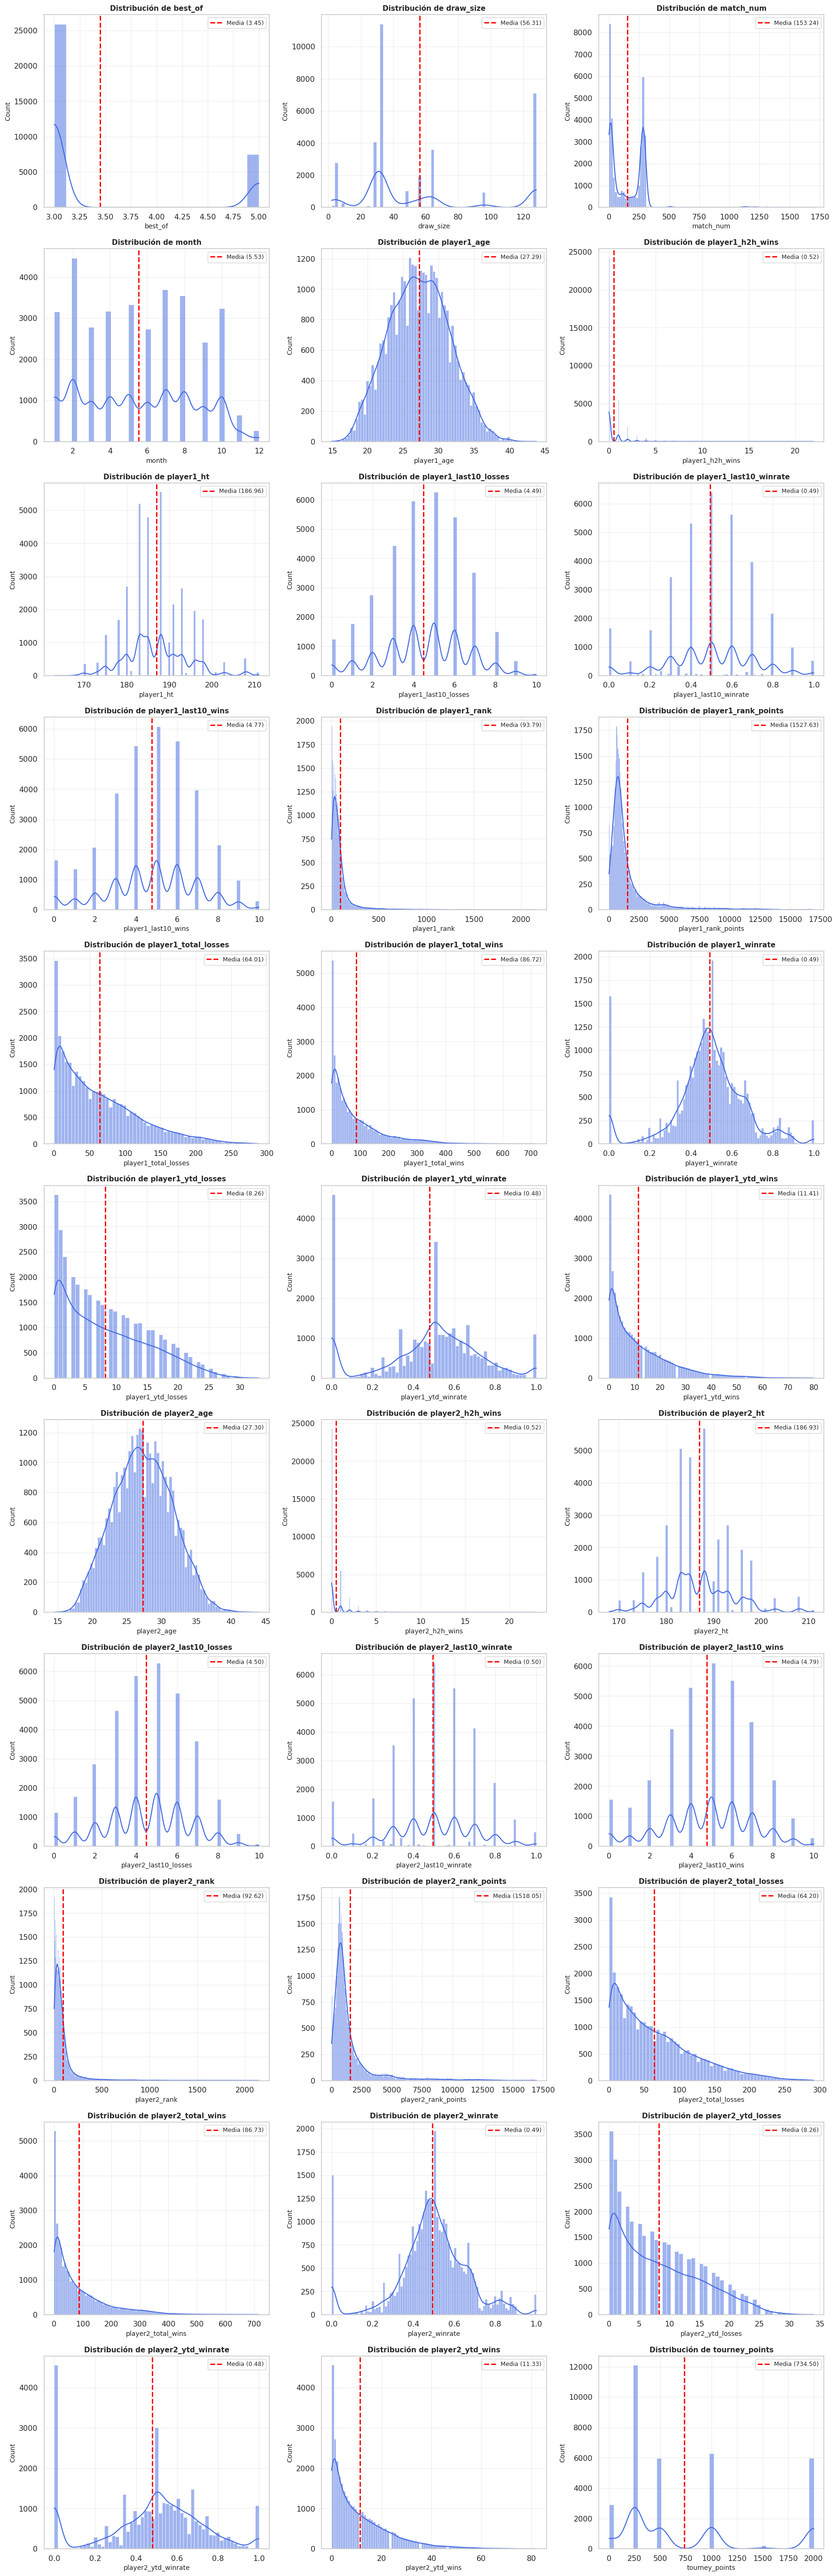


Se han generado 33 histogramas en 11 fila(s) de 3 columnas
Variables numéricas procesadas: ['best_of', 'draw_size', 'match_num', 'month', 'player1_age', 'player1_h2h_wins', 'player1_ht', 'player1_last10_losses', 'player1_last10_winrate', 'player1_last10_wins', 'player1_rank', 'player1_rank_points', 'player1_total_losses', 'player1_total_wins', 'player1_winrate', 'player1_ytd_losses', 'player1_ytd_winrate', 'player1_ytd_wins', 'player2_age', 'player2_h2h_wins', 'player2_ht', 'player2_last10_losses', 'player2_last10_winrate', 'player2_last10_wins', 'player2_rank', 'player2_rank_points', 'player2_total_losses', 'player2_total_wins', 'player2_winrate', 'player2_ytd_losses', 'player2_ytd_winrate', 'player2_ytd_wins', 'tourney_points']


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_numeric_histograms(matches_train, numerical_columns, *,
                            exclude=('year',), n_cols=3, kde=True, color='#4169E1'):
    """
    Dibuja histogramas (con KDE opcional) para columnas numéricas reales
    de matches_train[numerical_columns], excluyendo las de `exclude`.
    También traza una línea vertical en la media.
    Devuelve la lista de columnas procesadas (true_numerical_columns).
    """
    # Filtrar columnas numéricas y excluir no deseadas
    true_numerical_columns = (
        matches_train[numerical_columns]
        .select_dtypes(include=[np.number])
        .columns.difference(exclude)
        .tolist()
    )

    n_vars = len(true_numerical_columns)
    if n_vars == 0:
        print("No hay columnas numéricas para graficar.")
        return []

    n_rows = (n_vars + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
    axes = np.atleast_1d(axes).ravel()

    for idx, col in enumerate(true_numerical_columns):
        ax = axes[idx]
        serie = matches_train[col].dropna()
        avg_value = serie.mean()

        _ = sns.histplot(serie, kde=kde, ax=ax, color=color)
        _ = ax.axvline(avg_value, color='red', linestyle='--',
                       label=f'Media ({avg_value:.2f})', linewidth=2)
        _ = ax.set_title(f'Distribución de {col}', fontsize=11, fontweight='bold')
        _ = ax.set_xlabel(col, fontsize=10)
        _ = ax.set_ylabel('Count', fontsize=10)
        _ = ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)

    # Ocultar subplots vacíos
    for i in range(n_vars, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()
    plt.close(fig)  # evita re-mostrado en algunos entornos

    print(f"\nSe han generado {n_vars} histogramas en {n_rows} fila(s) de {n_cols} columnas")
    print(f"Variables numéricas procesadas: {true_numerical_columns}")

    return true_numerical_columns

# === LLAMADA INTEGRADA (ajusta exclude si quieres quitar más columnas) ===
true_numerical_columns = plot_numeric_histograms(
    matches_train,
    numerical_columns,
    exclude=('year',),      # añade aquí otras columnas a excluir si aplica
    n_cols=3,
    kde=True,
    color='#4169E1'
)


#### 2.2.2-Variables Categóricas:

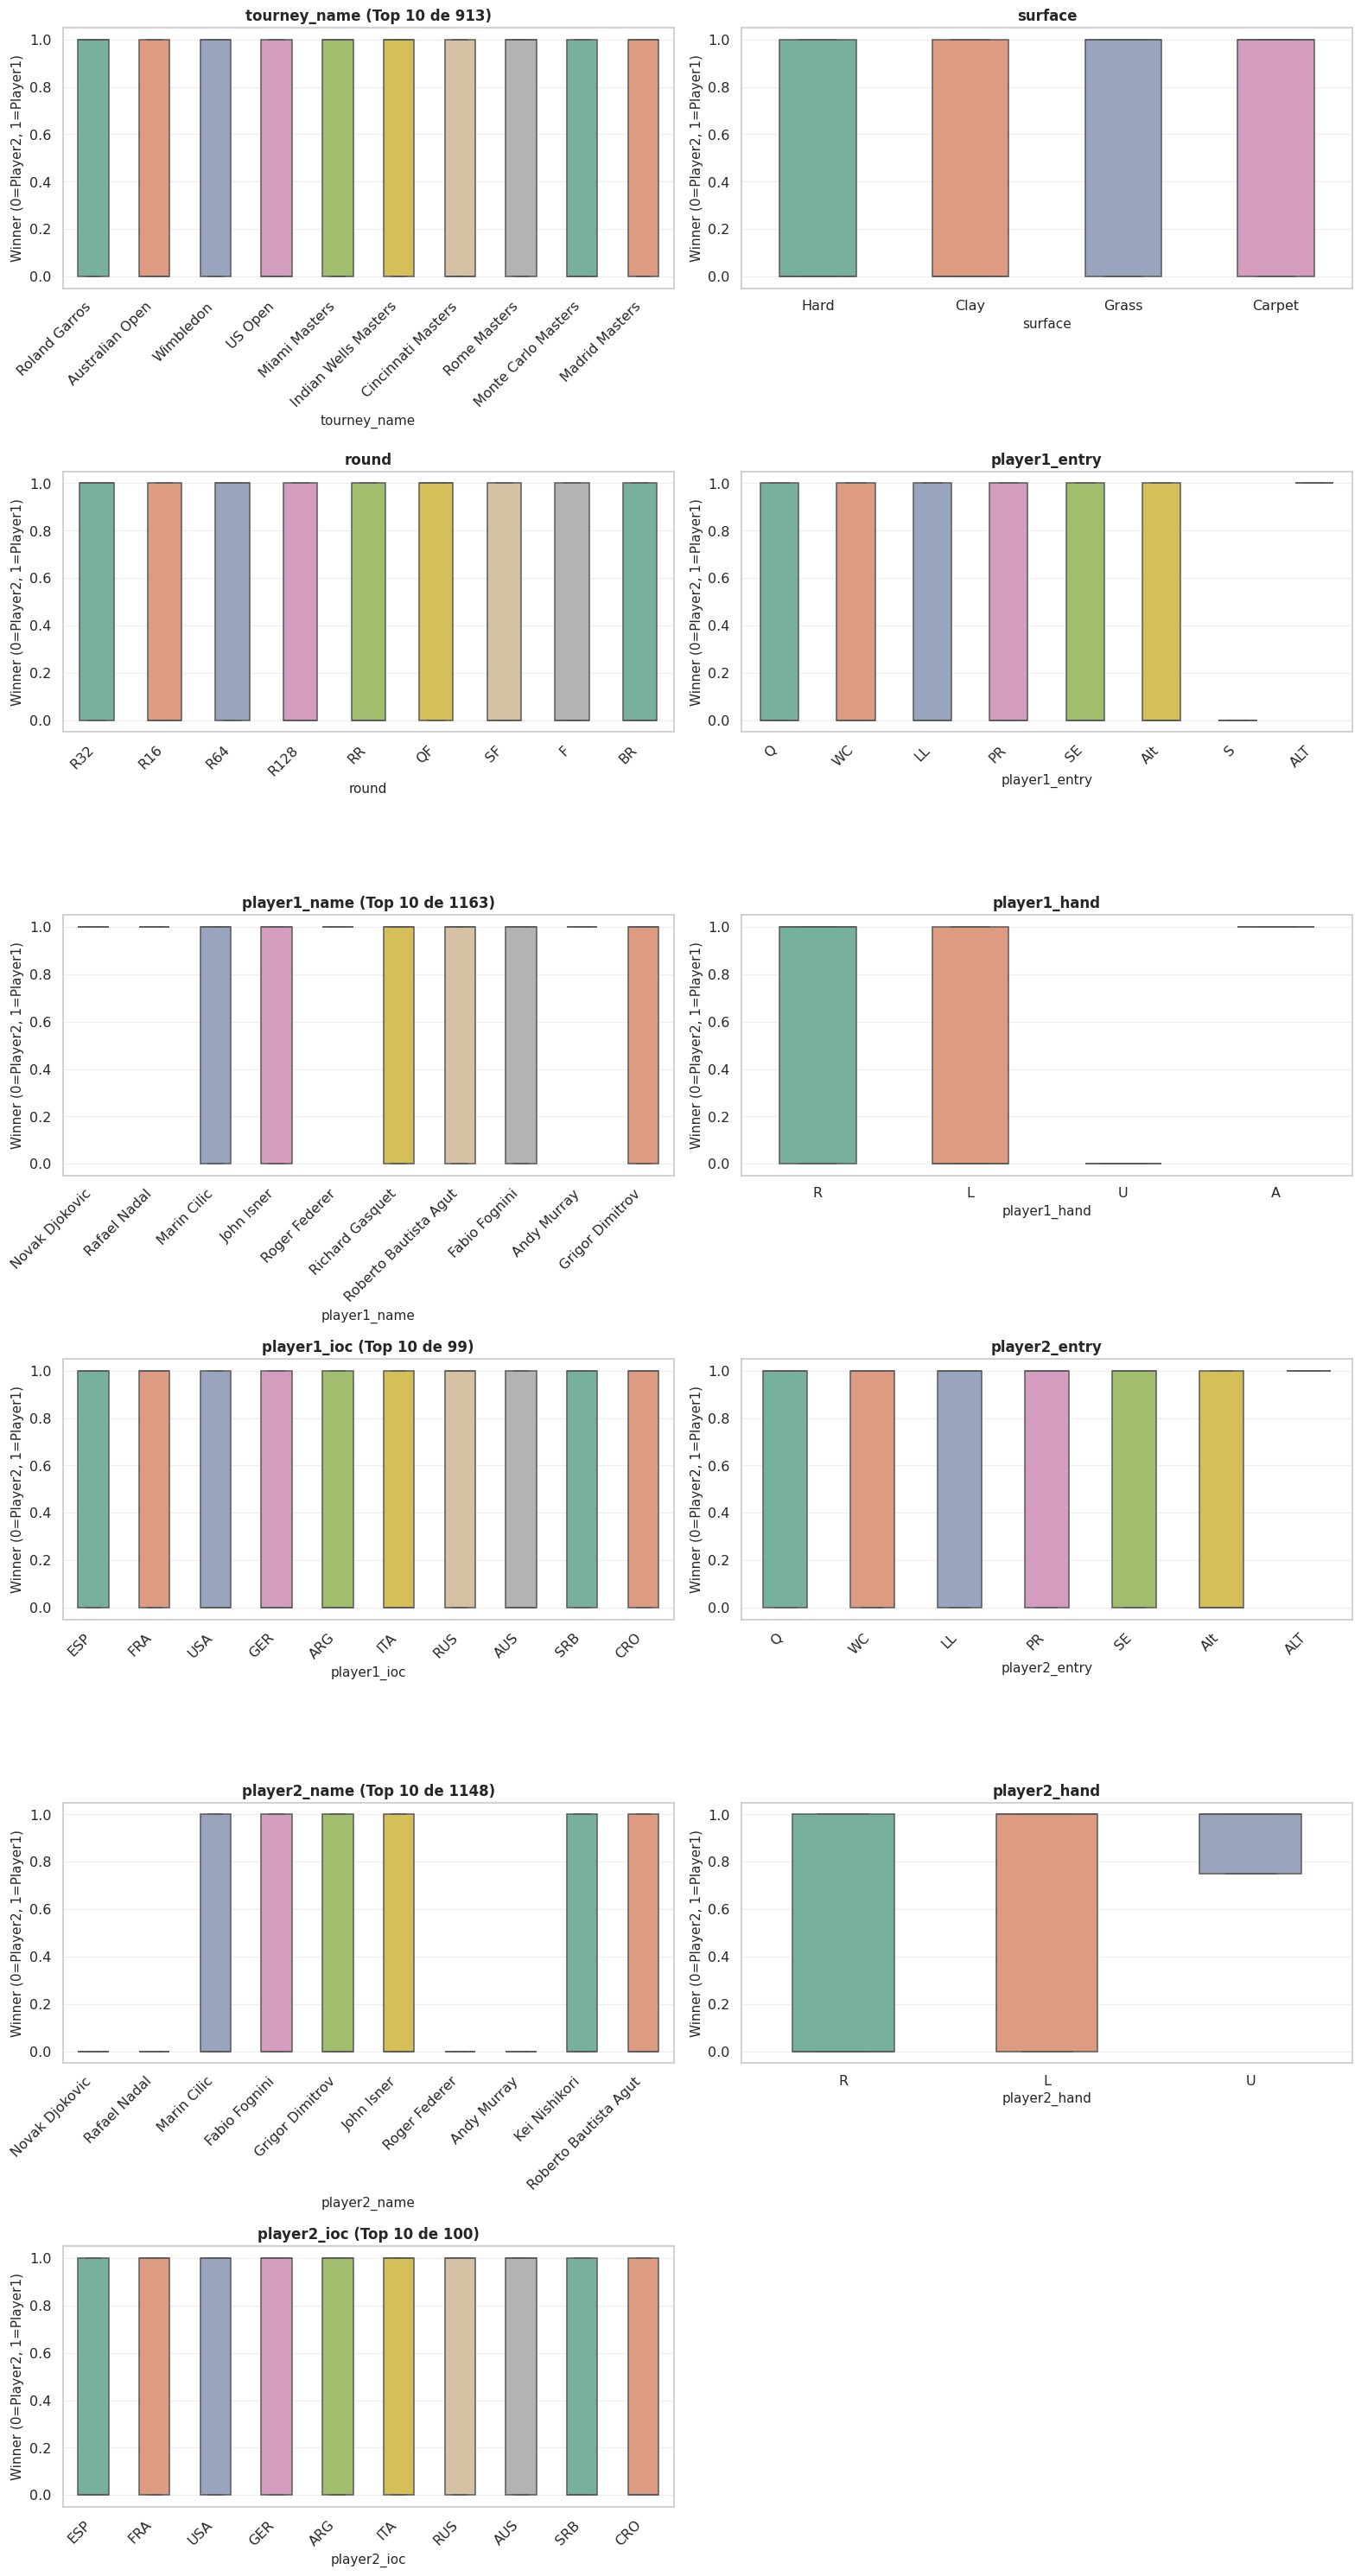


📊 Se han generado 11 gráficos de variables categóricas
   Distribución: 6 fila(s) × 2 columna(s)


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_categorical_boxplots(
    matches_train,
    categorical_columns,
    *,
    y_col='winner',
    top_k=10,
    n_cols=2,
    base_palette='Set2',  # Set2/Set3/pastel son suaves
    alpha=0.6,            # menos alpha => colores menos fuertes
    desat=0.8             # desaturación (0..1)
):
    """
    Boxplots de variables categóricas (x) frente a y_col, con paleta suave.
    - Si hay > top_k categorías, toma las top_k más frecuentes.
    - Corrige el FutureWarning: mapea colores con hue=x y elimina la leyenda.
    Devuelve la lista de columnas categóricas procesadas.
    """
    n_cat_vars = len(categorical_columns)
    if n_cat_vars == 0:
        print("No hay variables categóricas para graficar.")
        return []

    n_rows = (n_cat_vars + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 5))
    axes = np.atleast_1d(axes).ravel()

    for i, col in enumerate(categorical_columns):
        ax = axes[i]

        # Orden por frecuencia (excluyendo NaN para evitar problemas en 'order')
        vc = matches_train[col].value_counts(dropna=True)
        total_cats = len(vc)

        if total_cats > top_k:
            order = vc.head(top_k).index.tolist()
            data_filtered = matches_train[matches_train[col].isin(order)].copy()
            titulo_extra = f" (Top {top_k} de {total_cats})"
        else:
            order = vc.index.tolist()
            data_filtered = matches_train.copy()
            titulo_extra = ""

        # Quitar NaN en x e y para el boxplot
        data_filtered = data_filtered.dropna(subset=[col, y_col])

        # Paleta suave: base + desaturación + alpha
        n_colors = len(order)
        base = sns.color_palette(base_palette, n_colors)
        base_desat = [sns.desaturate(c, desat) for c in base]
        palette_rgba = [(*c, alpha) for c in base_desat]

        # === PLOT ===
        # Nota: usamos hue=col y hue_order=order, así el color se asigna por categoría
        # y se elimina la advertencia. Quitamos la leyenda para no duplicar info.
        _ = sns.boxplot(
            data=data_filtered,
            x=col,
            y=y_col,
            order=order,
            hue=col,             # <- clave para el mapeo de color
            hue_order=order,
            palette=palette_rgba,
            ax=ax,
            width=0.5,
            dodge=False,         # como hue == x, evitamos cualquier desplazamiento
            flierprops=dict(marker='o', markersize=3, markeredgewidth=0, alpha=max(0.2, alpha-0.3)),
            linewidth=1.1
        )

        # Eliminar leyenda (no aporta aquí)
        leg = ax.get_legend()
        if leg is not None:
            leg.remove()

        # Asegurar alpha en los parches (por si alguna versión lo ignora en palette)
        for patch in ax.artists:
            patch.set_alpha(alpha)

        # Configuración
        _ = ax.set_title(f'{col}{titulo_extra}', fontsize=12, fontweight='bold')
        _ = ax.set_xlabel(col, fontsize=11)
        _ = ax.set_ylabel('Winner (0=Player2, 1=Player1)', fontsize=11)
        ax.grid(True, alpha=0.3, axis='y')

        # Rotar etiquetas si hay muchas categorías
        if len(order) > 5:
            plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    # Ocultar ejes sobrantes
    for j in range(n_cat_vars, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()
    plt.close(fig)

    print(f"\n📊 Se han generado {n_cat_vars} gráficos de variables categóricas")
    print(f"   Distribución: {n_rows} fila(s) × {n_cols} columna(s)")

    return categorical_columns

# === LLAMADA INTEGRADA ===
categorical_columns_procesadas = plot_categorical_boxplots(
    matches_train,
    categorical_columns,
    y_col='winner',
    top_k=10,
    n_cols=2,
    base_palette='Set2',   # prueba también 'pastel' o 'Set3'
    alpha=0.6,
    desat=0.8
)


## 3.Correlaciones con la variable objetivo

/tmp/ipykernel_3095/4165576555.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(bar_cmap)


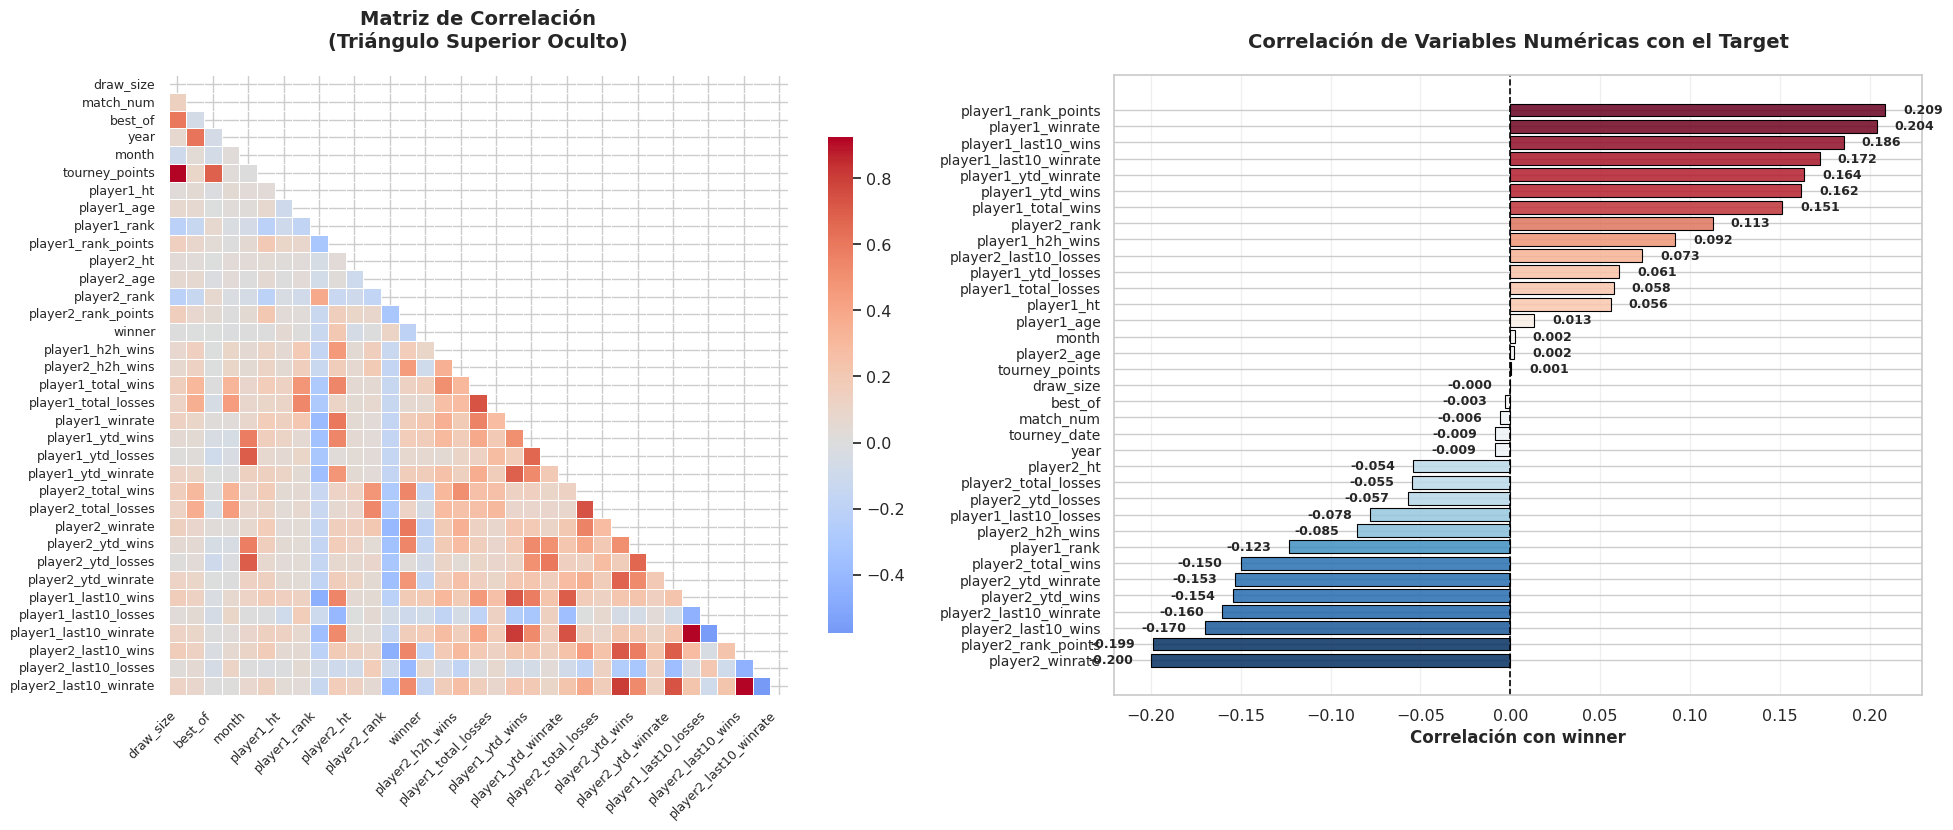

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm, colors as mcolors

def plot_correlation_panels(
    matches_train,
    numerical_columns,
    *,
    target='winner',
    mask_upper=True,
    heatmap_cmap='vlag',     # paleta divergente suave para el heatmap
    bar_cmap='RdBu_r',       # gradiente rojo-azul para barras
    alpha=0.85,              # transparencia agradable
    top_k_print=5
):
    """
    Dibuja:
      1) Heatmap de correlaciones (con triángulo superior opcionalmente oculto).
      2) Barras horizontales de correlación de cada numérica con `target`.

    Suprime salidas intermedias típicas de Jupyter y devuelve la serie de
    correlaciones con el target (ordenada).
    """
    if target not in matches_train.columns:
        print(f"La columna objetivo '{target}' no existe en el DataFrame.")
        return None

    # === HEATMAP DE CORRELACIÓN ===
    corr = matches_train.corr(numeric_only=True)
    mask = np.triu(np.ones_like(corr, dtype=bool)) if mask_upper else None

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    ax1, ax2 = axes

    _ = sns.heatmap(
        corr,
        mask=mask,
        cmap=heatmap_cmap,
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.8},
        ax=ax1,
        annot=False
    )
    _ = ax1.set_title('Matriz de Correlación\n(Triángulo Superior Oculto)',
                      fontsize=14, fontweight='bold', pad=20)
    _ = plt.setp(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=9)
    _ = plt.setp(ax1.get_yticklabels(), rotation=0, fontsize=9)

    # === CORR CON TARGET (BARRAS) ===
    cols = [c for c in numerical_columns if c in matches_train.columns and c != target]
    corrs = matches_train[cols].corrwith(matches_train[target]).dropna().sort_values(ascending=True)

    idx = np.arange(len(corrs))
    cmap = cm.get_cmap(bar_cmap)
    # Escala centrada en 0 para colorear por signo/magnitud
    norm = mcolors.TwoSlopeNorm(vmin=float(corrs.min()), vcenter=0.0, vmax=float(corrs.max()))
    bar_colors = [(*cmap(norm(v))[:3], alpha) for v in corrs.values]

    bars = ax2.barh(idx, corrs.values, color=bar_colors, edgecolor='black', linewidth=0.8)
    _ = ax2.set_yticks(idx)
    _ = ax2.set_yticklabels(corrs.index, fontsize=10)
    _ = ax2.set_xlabel(f'Correlación con {target}', fontsize=12, fontweight='bold')
    _ = ax2.set_title('Correlación de Variables Numéricas con el Target',
                      fontsize=14, fontweight='bold', pad=20)
    _ = ax2.axvline(x=0, color='black', linewidth=1.2, linestyle='--')
    ax2.grid(True, alpha=0.3, axis='x')

    for i, (bar, val) in enumerate(zip(bars, corrs.values)):
        offs = 0.01 if val > 0 else -0.01
        _ = ax2.text(val + offs, i, f'{val:.3f}',
                     ha='left' if val > 0 else 'right',
                     va='center', fontsize=9, fontweight='bold')

    plt.tight_layout()
    plt.show()
    plt.close(fig)
    return corrs

# === LLAMADA INTEGRADA ===
correlaciones = plot_correlation_panels(
    matches_train,
    numerical_columns,
    target='winner',
    mask_upper=True,
    heatmap_cmap='coolwarm',    # prueba también 'coolwarm', 'icefire', 'PuOr'
    bar_cmap='RdBu_r',
    alpha=0.85,
    top_k_print=5
)


## 4-Entrenamiento con regresión logística

Vamos a entrenar con una regresión simple: la regresión logística para ver si tenemos más de un 50% (aleatoriedad) de acierto, si no fuese el caso, estaríamos hablando de un dataset demasiado complicado.

No vamos a hacer un preprocesado extenso, vamos a simplemente eliminar filas con algun problema, esto nos lo reservamos para la siguiente entrega. Además no trataremos las variables categóricas: el modelo con simplemente las variables numéricas debería ser posible de superar el 50% de acierto.

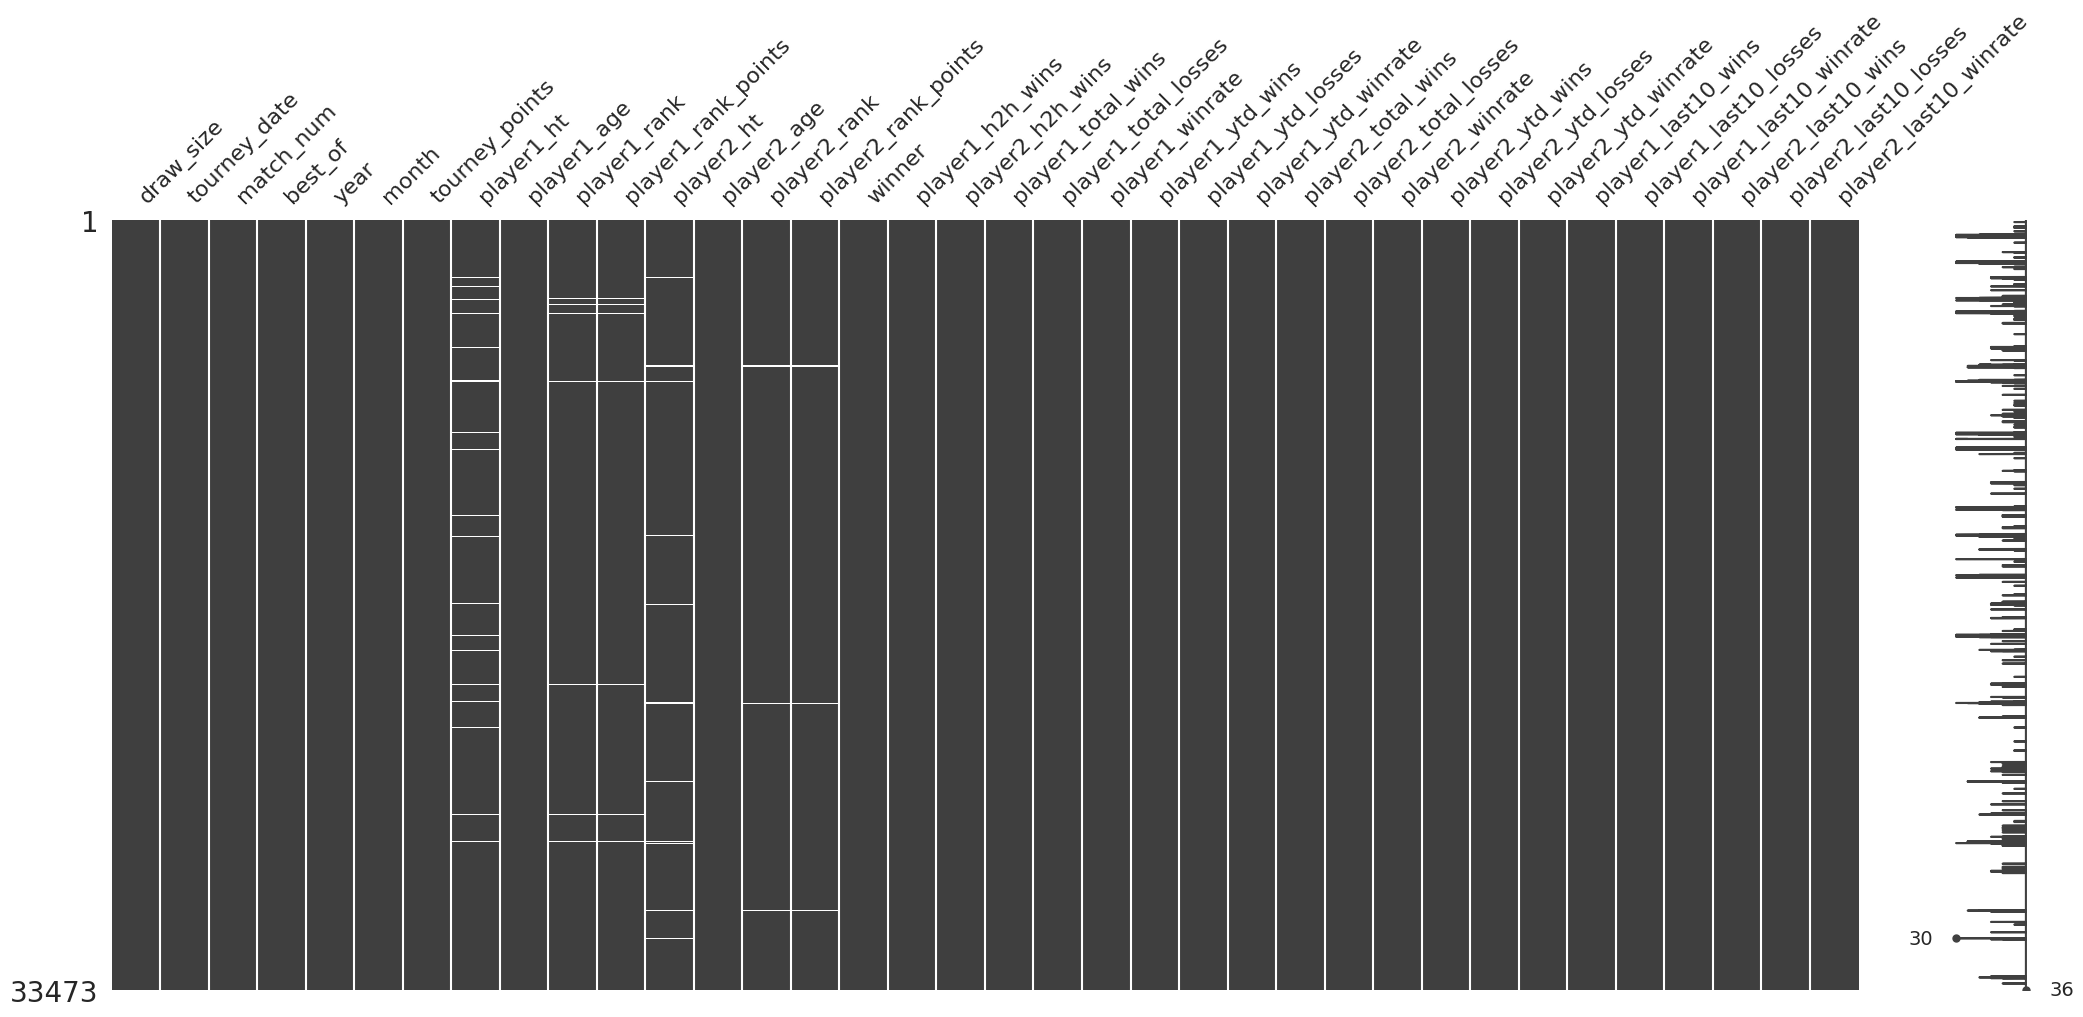

In [11]:
# droppeamos las categóricas:
matches_train.drop(columns=categorical_columns, inplace=True)
matches_test.drop(columns=categorical_columns, inplace=True)

msno.matrix(matches_train);

Vamos a eliminar las filas problemáticas (repito, solo para esta primera entrega, por simplicidad).

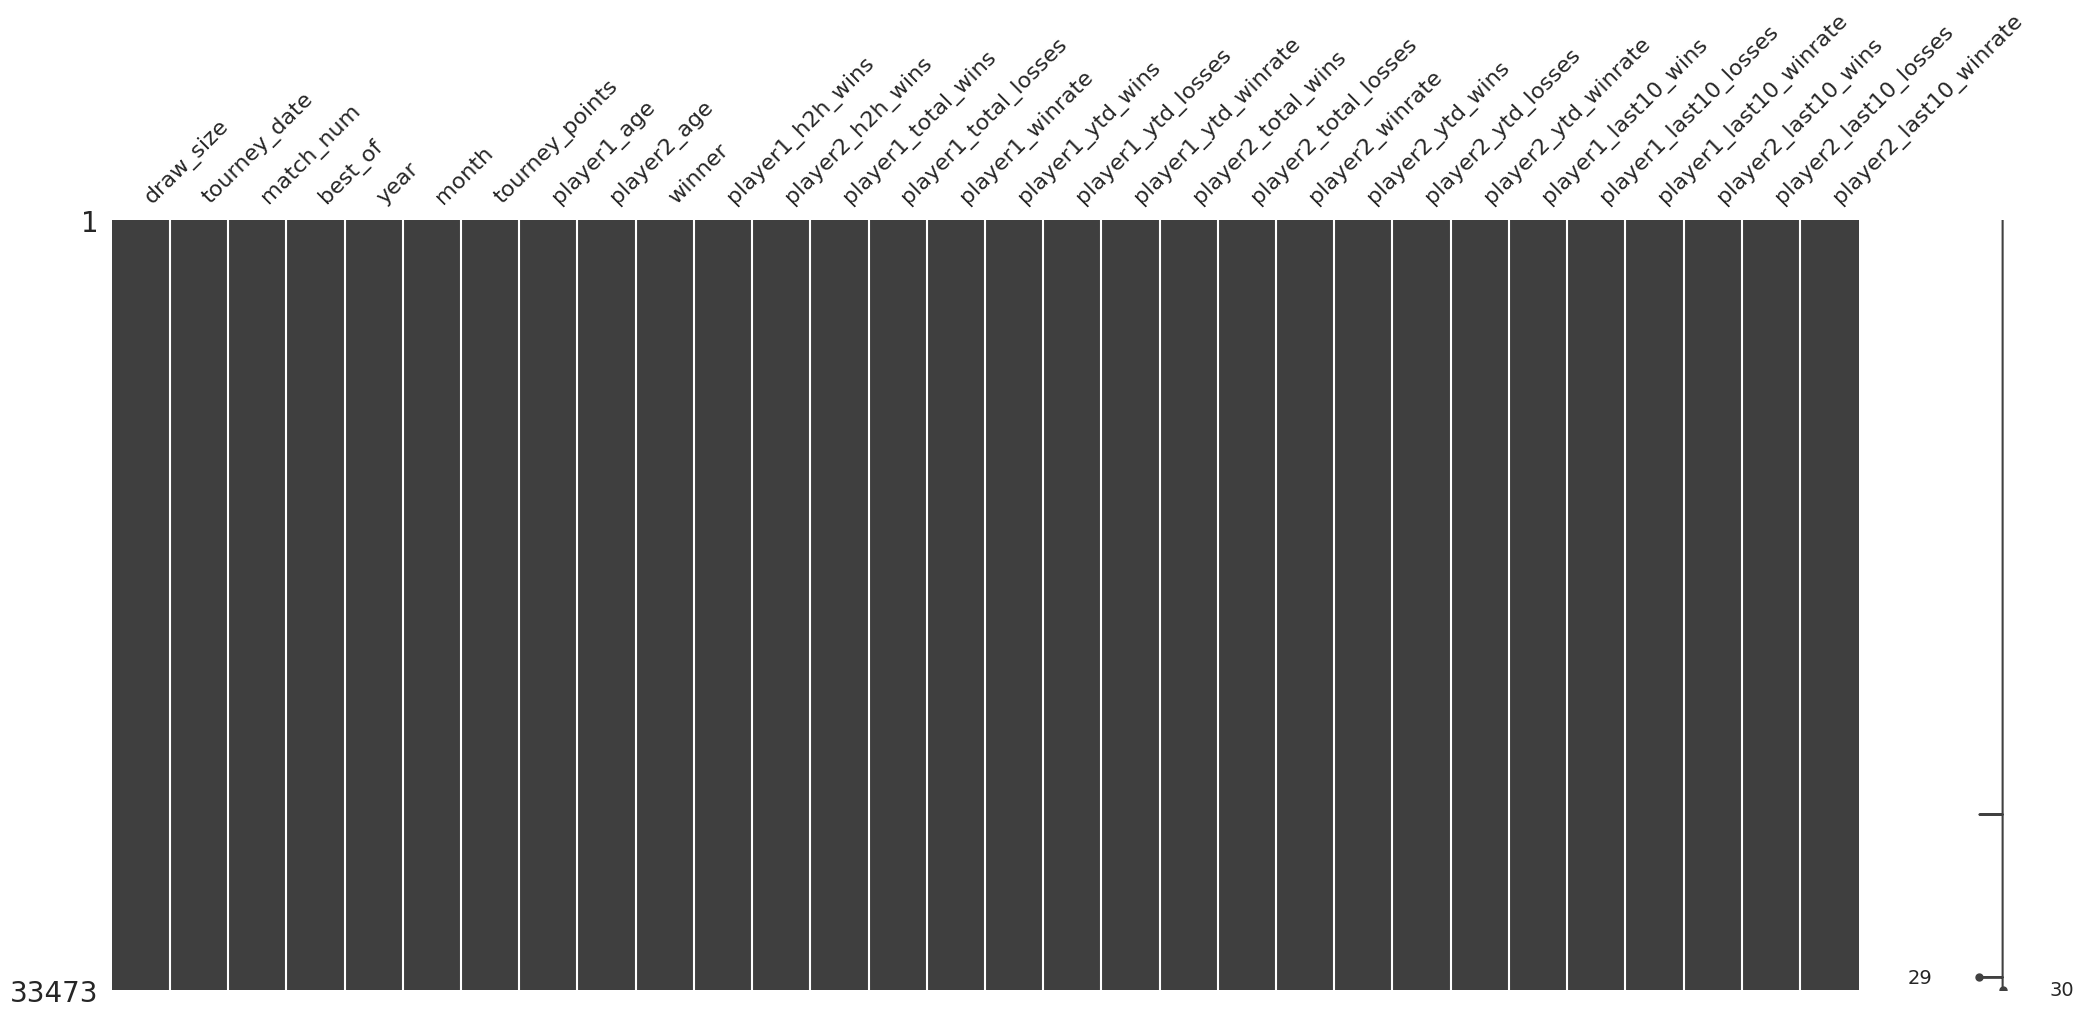

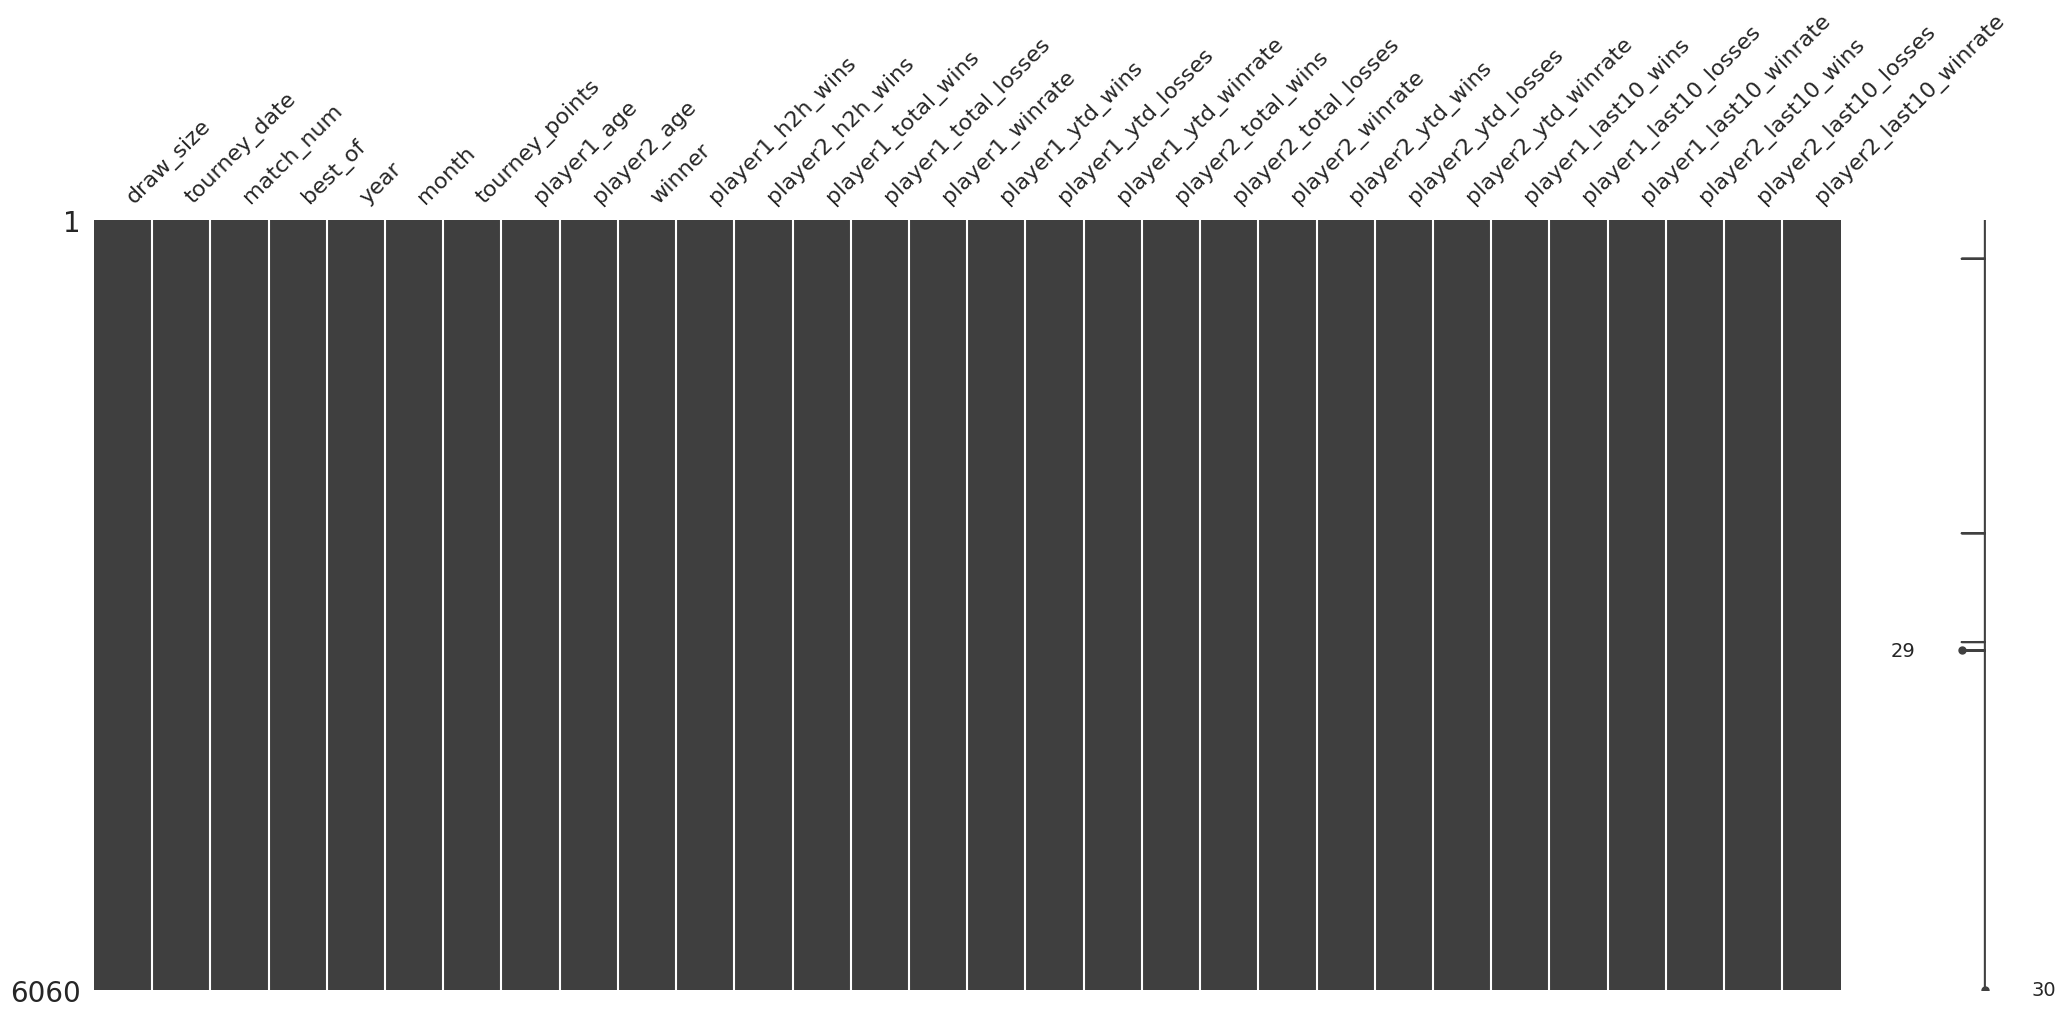

In [12]:
matches_train = matches_train.drop(columns=['player1_ht', 'player1_rank', 'player1_rank_points',
                                            'player2_ht', 'player2_rank', 'player2_rank_points'])
matches_test = matches_test.drop(columns=['player1_ht', 'player1_rank', 'player1_rank_points',
                                          'player2_ht', 'player2_rank', 'player2_rank_points'])

msno.matrix(matches_train);

msno.matrix(matches_test);

Problema solucionado.

In [ ]:
# --- Eliminar NaNs por separado ---
train_original = len(matches_train)
test_original = len(matches_test)

matches_train = matches_train.dropna()
matches_test = matches_test.dropna()

print(f"Train: eliminadas {train_original - len(matches_train)} filas con NaN.")
print(f"Test: eliminadas {test_original - len(matches_test)} filas con NaN.")

X_train = matches_train.drop(columns=[target])
y_train = matches_train[target]

X_test = matches_test.drop(columns=[target])
y_test = matches_test[target]

# escalar
scaler = StandardScaler()

# Aprender con el conjunto de entrenamiento y aplicar la transformación 
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])

# Aplicar la transformación al conjunto de test
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])

X_train.head()

Train: eliminadas 2 filas con NaN.
Test: eliminadas 4 filas con NaN.


,draw_size,tourney_date,match_num,best_of,year,month,tourney_points,player1_age,player2_age,player1_h2h_wins,...,player2_winrate,player2_ytd_wins,player2_ytd_losses,player2_ytd_winrate,player1_last10_wins,player1_last10_losses,player1_last10_winrate,player2_last10_wins,player2_last10_losses,player2_last10_winrate
0,-0.588138,-1.540824,-0.978765,-0.538863,-1.527675,-1.508588,-0.726955,-2.049613,-0.237054,-0.422572,...,-2.798362,-0.942835,-1.200198,-1.892588,-2.151389,-2.176165,-2.273854,-2.166525,-2.191824,-2.294301
1,-0.588138,-1.540824,-0.972336,-0.538863,-1.527675,-1.508588,-0.726955,0.756226,-0.379219,-0.422572,...,-2.798362,-0.942835,-1.200198,-1.892588,-2.151389,-2.176165,-2.273854,-2.166525,-2.191824,-2.294301
2,-0.588138,-1.540824,-0.965908,-0.538863,-1.527675,-1.508588,-0.726955,-0.988582,-1.374373,-0.422572,...,-2.798362,-0.942835,-1.200198,-1.892588,-2.151389,-2.176165,-2.273854,-2.166525,-2.191824,-2.294301
3,-0.588138,-1.540824,-0.959479,-0.538863,-1.527675,-1.508588,-0.726955,-1.200788,-0.710937,-0.422572,...,-2.798362,-0.942835,-1.200198,-1.892588,-2.151389,-2.176165,-2.273854,-2.166525,-2.191824,-2.294301
4,-0.588138,-1.540824,-0.953051,-0.538863,-1.527675,-1.508588,-0.726955,-1.130053,0.402688,-0.422572,...,-2.798362,-0.942835,-1.200198,-1.892588,-2.151389,-2.176165,-2.273854,-2.166525,-2.191824,-2.294301


In [14]:
# CELDA DE VERIFICACIÓN
# Comprueba si X_train tiene NaNs
nans_en_train = X_train.isnull().sum().sum()
print(f"Número total de NaNs en X_train: {nans_en_train}")

# Comprueba si X_test tiene NaNs
nans_en_test = X_test.isnull().sum().sum()
print(f"Número total de NaNs en X_test: {nans_en_test}")

Número total de NaNs en X_train: 0
Número total de NaNs en X_test: 0


Aplicamos la regresión logística

Entrenando modelos...


,estimator,LogisticRegre...ndom_state=16)
,param_grid,"{'C': [0.001, 0.01, ...], 'class_weight': [None, 'balanced']}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,TimeSeriesSpl...est_size=None)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'



TOP 5 MODELOS PROBADOS (Validación Cruzada)
 Ranking  CV Accuracy Promedio  Desviación Std  Valor C Peso Clases
       1              0.669129        0.015910     0.01        None
       2              0.669057        0.016027     0.01    balanced
       3              0.668268        0.015724     0.10    balanced
       4              0.667838        0.015005     0.10        None
       5              0.665722        0.013536     1.00        None
--------------------------------------------------

RESUMEN EJECUTIVO (Modelo Ganador)
Mejor Configuración:      C = 0.01, Pesos = None
CV Accuracy (Validación): 66.91% (Promedio durante entrenamiento)
Test Accuracy (Real):     64.46% (Datos nuevos/futuro)
✅  ESTADO: El modelo es robusto y generaliza bien.


<Figure size 600x400 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Matriz de Confusión (Datos de Test)')

Text(41.25, 0.5, 'Verdadero')

Text(0.5, 10.249999999999995, 'Predicho')

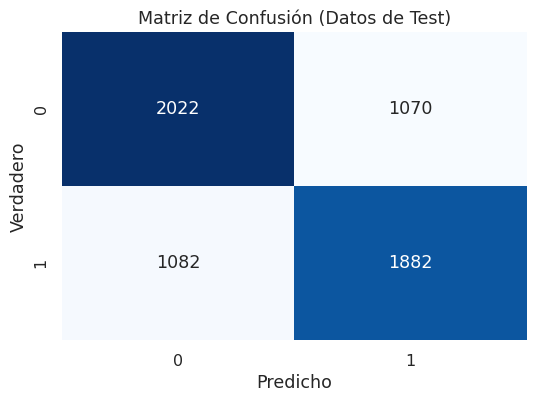

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# ... (Asumimos que X_train, X_test, y_train, y_test ya están cargados y ordenados por fecha) ...

# 1. Configuración (Igual que antes)
tscv = TimeSeriesSplit(n_splits=5)
base_model = LogisticRegression(max_iter=5000, random_state=16)

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10], # Probamos varias fuerzas de regularización
    'class_weight': [None, 'balanced'] # Útil si tienes clases desbalanceadas
}

grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=tscv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=0 # Ponemos 0 para que no ensucie la pantalla mientras entrena
)

# 2. Entrenar
print("Entrenando modelos...")
grid_search.fit(X_train, y_train)

# --- AQUI ESTÁ LA MEJORA DEL OUTPUT ---

# 3. Convertir resultados a DataFrame para ver el ranking
# cv_results_ contiene todos los detalles de cada prueba
results_df = pd.DataFrame(grid_search.cv_results_)

# Seleccionamos solo las columnas importantes para leer fácil
cols_to_show = ['rank_test_score', 'mean_test_score', 'std_test_score', 'param_C', 'param_class_weight']
results_df = results_df[cols_to_show].sort_values(by='rank_test_score')

# Renombramos columnas para que se vea bonito en español
results_df.columns = ['Ranking', 'CV Accuracy Promedio', 'Desviación Std', 'Valor C', 'Peso Clases']

print("\n" + "="*50)
print("TOP 5 MODELOS PROBADOS (Validación Cruzada)")
print("="*50)
# Mostramos la tabla limpia sin índices feos
print(results_df.head(5).to_string(index=False))
print("-" * 50)

# 4. Evaluación Final del Ganador
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
best_cv_acc = grid_search.best_score_

print("\n" + "="*50)
print("RESUMEN EJECUTIVO (Modelo Ganador)")
print("="*50)
print(f"Mejor Configuración:      C = {grid_search.best_params_['C']}, Pesos = {grid_search.best_params_['class_weight']}")
print(f"CV Accuracy (Validación): {best_cv_acc:.2%} (Promedio durante entrenamiento)")
print(f"Test Accuracy (Real):     {test_acc:.2%} (Datos nuevos/futuro)")

# Detección rápida de Overfitting
diff = best_cv_acc - test_acc
if diff > 0.05:
    print(f"⚠️  ALERTA: El modelo cae un {diff:.2%} en test. Posible Overfitting.")
elif diff < -0.05:
    print(f"⚠️  ALERTA: El resultado en test es sospechosamente alto.")
else:
    print(f"✅  ESTADO: El modelo es robusto y generaliza bien.")
print("="*50)

# 5. (Opcional) Matriz de Confusión Visual
# Si estás en Jupyter, esto generará un gráfico bonito
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión (Datos de Test)')
plt.ylabel('Verdadero')
plt.xlabel('Predicho')
plt.show()